# New and improved Parflow IO routines, integration with `xarray`, and some nifty tools for you non-Parflowheads

This notebook details some of the new Parflow IO routines in the Parflow python package. As of Jan 27, 2022 they are not quite in the main repo, so can't be `pip` installed yet. But that should happen soon - for those interested here's the [pull request](https://github.com/parflow/parflow/pull/365). This tutorial can also be run via binder through [this link](https://mybinder.org/v2/gh/arbennett/group_meeting_feb1/HEAD), alternatively here is [the GitHub repo](https://github.com/arbennett/group_meeting_feb1).

## First up - why?

I first undertook this rewrite because I found some flaws in the existing workflow for the Parflow IO routines. First, there was an underlying memory leak because of the way that the ParflowIO package holds a copy of data in the background and you interact with the data by copying it (or pieces of it). Second, it was very slow to pull out timeseries because of the way that ParflowIO reads the file header and subgrid headers every time you open a file, which ends up being a rather large overhead when you are reading thousands of files. This new method addresses both of these problems, as well as offers some other nice benefits. It is written in pure python so it is easier to understand and modify. I have also written a backend to the [xarray](https://xarray.pydata.org/en/stable/) python package, which is massively useful for data analysis.

## What you will get out of this tutorial/notebook/demo/thing

Okay, so that was the motivation for me to do all of this work, but what's in it for you? By putting together this notebook I hope to convince you that the new tools offer a compelling and performant way to analyze Parflow output. For those not really into Parflow specifically, I will show you some cool things like:

 * Loading data over the network from Google drive via [gdrivefs](https://github.com/fsspec/gdrivefs) (And more generally [fsspec](https://filesystem-spec.readthedocs.io/en/latest/?badge=latest#))
 * How xarray and the larger [Pangeo ecosystem](https://pangeo.io/) can make your data-analysis-life much easier and intuitive
 
Let's get to it - as always, starting with some imports and fixing up the plotting style.

In [175]:
import os
import numpy as np
import xarray as xr
import parflow as pf
import parflow.tools.io as pfio
import gdrivefs
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from glob import glob

# Set a bigger default plot size
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['font.size'] = 22

## Intro to `gdrivefs`, or how to interact with Google drive via the notebook

Because `git` doesn't like to have large datasets put into the repo I had to get a bit creative in making this tutorial open and accessible. There's this awesome library [fsspec](https://filesystem-spec.readthedocs.io/en/latest/?badge=latest#) that I mentioned earlier, which basically lets you access different filesystems directly in python. I've got a whole [(unfinished) blog post](http://arbennett.github.io/software,/machine-learning/2021/08/18/ml_infrastructure_for_eess_beginners.html) on using fsspec - but wanted to use Google Drive here because we have unlimited storage at UA. Enter `gdrivefs`, which is basically an implementation of `fsspec` on top of Google Drive. It's pretty bare-bones but works pretty well in my experience.

To get started, you can run the cell below which points to my files for the rest of the tutorial. When starting up the `gdrivefs` session you'll have to enter a token and allow access from the link provided. Once you have granted access you'll get a code that you should copy and paste into the box that appears below the cell. With that you'll have access to the files.

In [2]:
token = 'browser'
data_id = '1DMXwWqrF3-vhdYZcUU-RAYFYQv6BuL-T'
gdfs = gdrivefs.GoogleDriveFileSystem(token=token, root_file_id=data_id)
gdfs

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=mHBAMpjnx8wHGKkhdLyMCjotXpEAN4&prompt=consent&access_type=offline


Enter the authorization code:  4/1AX4XfWhagLiQHIHQAuzofMcxy2_Wt1iYG8GXUQjWVp-9QxPLRhPbBy0KMZc


### Looking at the data

With the connection to Google drive open you can interact with some Unix-like interfaces. First, let's just poke around and see the files using `ls` which just lists files and directories. You will see there are two directories here, `conus1_data` and `taylor_data`. Let's also see what's in the `conus1_data` directory by using `ls("conus1_data")` - you should see a bunch of files that we will analyze here.

In [3]:
gdfs.ls("")

['conus1_data', 'taylor_data']

In [4]:
gdfs.ls("conus1_data")

['conus1_data/CONUS.2004.out.press.00000.pfb',
 'conus1_data/PmE.flux.pfb',
 'conus1_data/drv_clmin.dat',
 'conus1_data/drv_clmin.restart.dat',
 'conus1_data/drv_clmin.startup.dat',
 'conus1_data/drv_vegm.fixed.dat',
 'conus1_data/drv_vegp.dat',
 'conus1_data/grid3d.v3.pfb',
 'conus1_data/slopex.pfb',
 'conus1_data/slopey.pfb']

### Getting the data

To start out, let's just look at this `CONUS.2004.out.press.00000.pfb` file. It's a Parflow output file of the pressure field in the subsurface, written in the parflow binary format. First we will download it with the `gdfs.download` function.

Then, we get to reading the file via the new `pf.read_pfb` function. You'll note that you no longer have to create a new object, then make function calls to get data out. This is much more streamlined and no longer keeps copies of the data in the background. With the data loaded into an array we can look at the shape - you'll note this is a pretty big array. Finally, we can just plot the mean taken in the vertical direction. I'm choosing the `gist_ncar` colormap so that tyou can see some of the variability more nicely than a sequential colormap. If you look closely you can see the great lakes and the Mississippi river!

In [56]:
filename = 'CONUS.2004.out.press.00000.pfb'
if not os.path.exists(filename):
    gdfs.download(f'/conus1_data/{filename}', 
                  filename)

In [62]:
pressure = pf.read_pfb(filename)
print(pressure.shape)

(5, 1888, 3342)


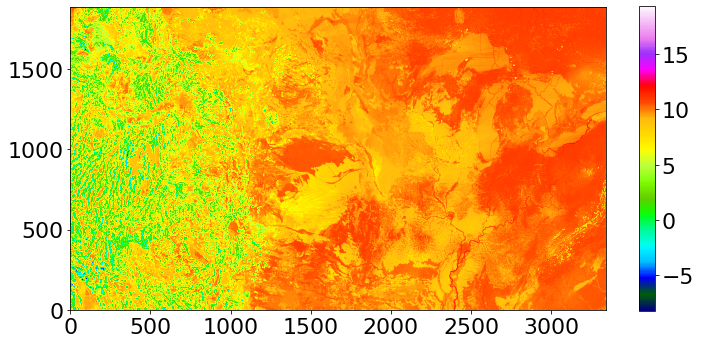

In [63]:
plt.imshow(np.mean(pressure, axis=0), cmap='gist_ncar')
plt.colorbar(shrink=0.7)
plt.gca().invert_yaxis()

### A short side diversion - multiple ways to read a PFB

Now, here is where I go back and complicate some stuff. If you look at the source code for `pf.read_pfb` you'll see something rather horrifying: We still do have a `ParflowBinaryReader` class which is implemented under the hood and still must be instantiated before use. However, it's still quite a bit cleaner, with a single call to `read_all_subgrids`. It's also implemented as a context manager, like how you would use python to open a text file, so there is no `open` or `close` calls to the file that you have to remember to use. Anyways... there's some other stuff under the hood here but I'm not going to get into it.

In [59]:
??pf.read_pfb

Signature: pf.read_pfb(file: str, mode: str = 'full', z_first: bool = True)
Source:   
def read_pfb(file: str, mode: str='full', z_first: bool=True):
    """
    Read a single pfb file, and return the data therein

    :param file:
        The file to read.
    :param mode:
        The mode for the reader. See ``ParflowBinaryReader::read_all_subgrids``
        for more information about what modes are available.
    :return:
        An nd array containing the data from the pfb file.
    """
    with ParflowBinaryReader(file) as pfb:
        data = pfb.read_all_subgrids(mode=mode, z_first=z_first)
    return data
File:      ~/workspace/group_meeting_feb1/binder/parflow/pftools/python/parflow/tools/io.py
Type:      function


<br>
We can quicky show that these two things are equivalent, and then delete both to reduce memory usage.

In [60]:
with pf.ParflowBinaryReader(filename) as pfb:
    pressure2 = pfb.read_all_subgrids()

In [61]:
print(np.sum(pressure2 - pressure))
del pressure, pressure2

0.0


### One timeslice is not enough though

Simulations and datasets tend to be spatiotemporal, and we're only looking at a single time slice so far. To look at time means we're going to add another axis, bumping up dimensionality. As the CONUS array was already big enough, let's move to a smaller domain for now. First we have to download the data - this will take a moment - in the mean time I have predownloaded the data so I can expound while you wait. Given a list of files you might be tempted to write a loop and run `pf.read_pfb` but this is actually quite inefficient, and the reason is the same as the reason that we have new IO routines at all. For your convenience I have implemented a more efficient method, `pf.read_stack_of_pfb` which takes a sequence of file names and reads them more efficiently. For this small example you'll see that both are relatively quick, but for large files this quickly adds up. Here it's still roughly 15-20% faster to read with the stack function. This is because we pre-cache the header & subgrid information and reuse that on subsequent reads.

In [97]:
if not os.path.exists('./taylor_pressure/'):
    os.mkdir('./taylor_pressure')
taylor_files = gdfs.ls("taylor_data/press") 
for i, f in enumerate(taylor_files):
    out_file = f'./taylor_pressure/{f.split("/")[-1]}'
    if not os.path.exists(out_file):
        gdfs.download(f, out_file)
    print(f'{np.around(100 * (i / len(taylor_files)), 1)}% done downloading...', end='\r')

taylor_files = glob('./taylor_pressure/*.pfb')

In [119]:
%time taylor_pressure_0 = np.stack([pf.read_pfb(f) for f in taylor_files])
%time taylor_pressure_1 = pf.read_stack_of_pfbs(taylor_files)
np.sum(taylor_pressure_1 - taylor_pressure_0)

CPU times: user 40.5 ms, sys: 8.84 ms, total: 49.4 ms
Wall time: 48.6 ms
CPU times: user 30.5 ms, sys: 8.84 ms, total: 39.4 ms
Wall time: 39.5 ms


0.0

<br>
Great, so just for demonstration purposes - here's a timeseries plot for a grid cell across depth layers. I've just done a normalizetion over time by dividing by the layers mean pressure value. This makes the scales more or less similar so that you can see differences in the layers over depths. Here you basically just see that as you go deeper in the ground you find a more damped response, unsurprisingly.

Text(0, 0.5, '$p(t) / \\bar{p(t)}$')

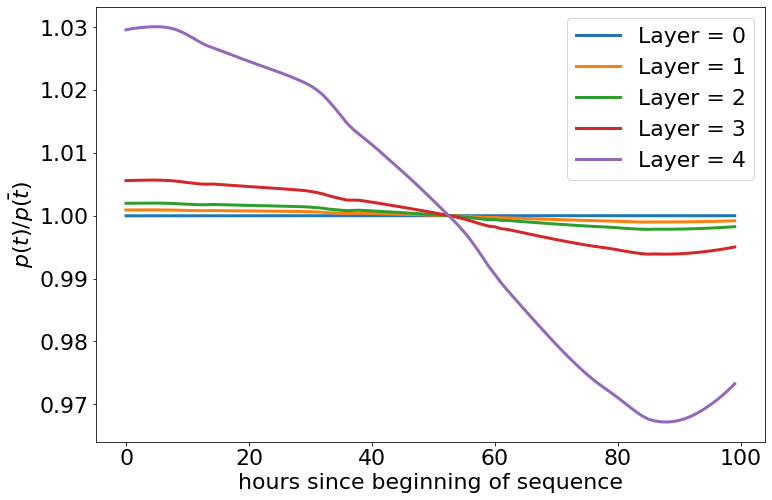

In [149]:
x_idx, y_idx = 20, 21
for z_idx in np.arange(5):
    p = taylor_pressure_1[:, z_idx, y_idx, x_idx]
    plt.plot(p / np.mean(p), label=f'Layer = {z_idx}', linewidth=3)
    
plt.legend()
plt.xlabel('hours since beginning of sequence')
plt.ylabel(r'$p(t) / \bar{p(t)}$')

In [ ]:
del taylor_pressure_1, taylor_pressure_0

### Let's move to something more interesting, interoperability with xarray

In this rewrite I've also done some work to make pfb files readable by xarray. I'll give a kind of crappy example here because a lot of the really useful functionality of xarray is still in development and I've mostly been using it for larger datasets than the binder instance can handle. I'll showcase some of that if time permits, but for now we need to do one last hacky thing - download the `vegm` file and use it to populate the latitudes and longitudes as coordinates. With it downloaded, opened via the hidden `_read_vegm` function (:eyeroll:) we can extract the lat and lons from the array (given you know how).

Anyways, without getting too worked up, we can open up our `pfb` file from earlier with `xr.open_dataset` and it will conveniently place the information into the dataset. We then record the coordinates, which are placed along a dimension axis and allow us to do some pretty nifty stuff very easily, such as plotting on map projections so we don't just have some weird abstract rectangle anymore.

In [241]:
filename = 'drv_vegm.fixed.dat'
if not os.path.exists(filename):
    gdfs.download(f'/conus1_data/{filename}', 
                  filename)
vegm_array = pfio._read_vegm(filename).T

In [242]:
ds = xr.open_dataset('./CONUS.2004.out.press.00000.pfb', name='pressure')
ds.coords['lat'] = xr.DataArray(vegm_array[0], dims=('y', 'x'))
ds.coords['lon'] = xr.DataArray(vegm_array[1], dims=('y', 'x'))
del vegm_array
ds.load()

<xarray.Dataset>
Dimensions:   (z: 5, y: 1888, x: 3342)
Coordinates:
    lat       (y, x) float64 31.65 31.65 31.66 31.66 ... 49.1 49.1 49.1 49.1
    lon       (y, x) float64 -116.0 -116.0 -116.0 -115.9 ... -76.13 -76.12 -76.1
Dimensions without coordinates: z, y, x
Data variables:
    pressure  (z, y, x) float64 49.88 49.91 50.18 ... 0.002225 0.05884 0.002049

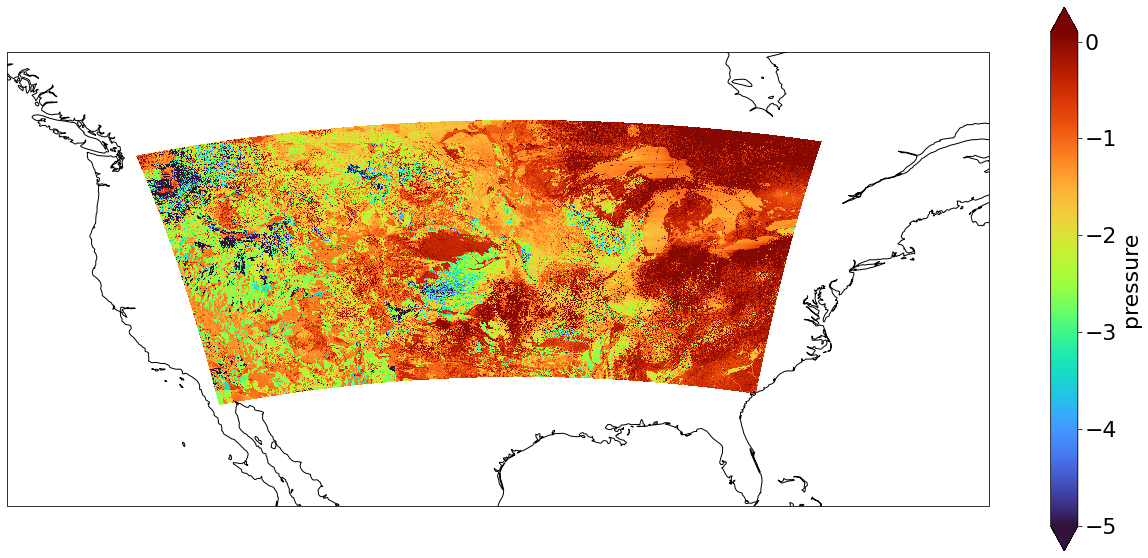

In [243]:
plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds['pressure'].isel(z=-1).plot(
    ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', vmin=-5, vmax=0.1, cmap='turbo'
)
ax.coastlines()
ax.set_ylim([25, 55])
ax.set_xlim([-130, -65]);